In [36]:
import numpy as np
import matplotlib.pyplot as plt
import sys, rospy, rosbag, glob, re

import scipy
import scipy.stats
from scipy.stats import pearsonr

from smap.msg import smapStats

import matplotlib.cm as cm
from matplotlib.colors import LogNorm

Plotting from ../build/repeated_fullmap_noise0.3_n/ ...
Log Odds 0.3_n RAMP: 544.35130929
CRM      0.3_n RAMP: 218.56294926
Plotting from ../build/repeated_fullmap_noise0.2_n/ ...
Log Odds 0.2_n RAMP: 733.653676826
CRM      0.2_n RAMP: 224.043774304
Plotting from ../build/repeated_fullmap_noise0.1_n/ ...
Log Odds 0.1_n RAMP: 669.415941166
CRM      0.1_n RAMP: 175.760471331
Plotting from ../build/repeated_fullmap_noise0.05_n/ ...
Log Odds 0.05_n RAMP: 452.155993859
CRM      0.05_n RAMP: 91.9036112533
Plotting from ../build/repeated_fullmap_noise0.01_n/ ...
Log Odds 0.01_n RAMP: 364.665564461
CRM      0.01_n RAMP: 7.37048061972


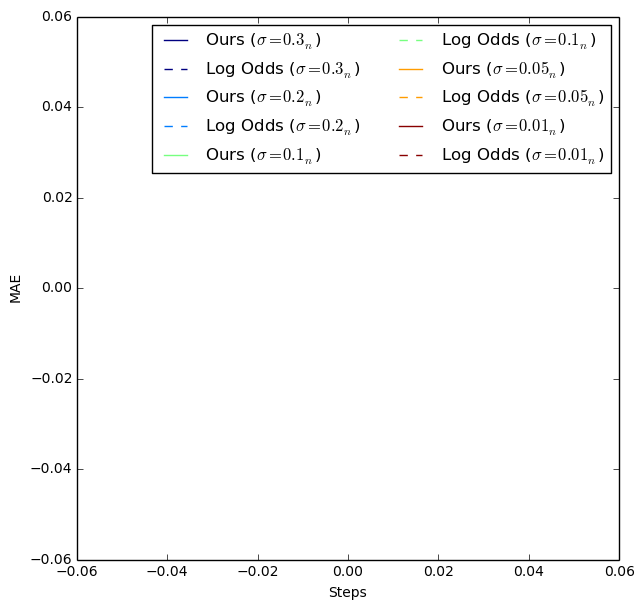

In [54]:
%matplotlib inline
fig, (ax) = plt.subplots(1, 1, figsize=(7, 7))
#ax.set_title("Full Map MAE Evolution")
ax.set_xlabel("Steps")
#ax.set_ylabel("MAE")

def hash_position(x, y, z):
    return "%.2f %.2f %.2f" % (x, y, z)

def plot_rounds(directory_name, noise_std, color_smap="b", color_logodds="g"):    
    directory_name = "../build/%s/" % directory_name
    print "Plotting from %s ..." % directory_name
    filenames = sorted(
        glob.glob(directory_name + "*.bag"),
        key=lambda f: int(re.findall('([0-9]+)', f[len(directory_name):])[0]))[:1]
    
    err_belief = []
    err_logodds = []

    steps = 0

    for rnd, filename in enumerate(filenames):
#         print "Evaluating round %i (%s)..." % (rnd, filename)
        bag = rosbag.Bag(filename)
        stats = None
        for _, msg, _ in bag.read_messages(topics=['stats']):
            stats = msg
        bag.close()
        if stats is None:
            continue

        steps = stats.step        
        err_belief.append(stats.errorEvolutionUpdatedBelief)
        err_logodds.append(stats.errorEvolutionUpdatedLogOdds)
        
        if rnd == 0:
            # compute inconsistencies
            gstep = 300
            #errLogOdds = np.abs(np.array(stats.errorCompleteLogOdds[(gstep-1) * stats.voxels:gstep * stats.voxels]))
            #errBelief= np.abs(np.array(stats.errorCompleteBelief[(gstep-1) * stats.voxels:gstep * stats.voxels]))
            #stdLogOdds = np.array(stats.stdCompleteLogOdds[(gstep-1) * stats.voxels:gstep * stats.voxels])
            #stdBelief = np.array(stats.stdCompleteBelief[(gstep-1) * stats.voxels:gstep * stats.voxels])
            
            errLogOdds = np.abs(np.array(stats.errorFinalUpdatedLogOdds))
            errBelief = np.abs(np.array(stats.errorFinalUpdatedBelief))
            stdLogOdds = np.abs(np.array(stats.stdFinalUpdatedLogOdds))
            stdBelief = np.abs(np.array(stats.stdFinalUpdatedBelief))
            
#             errLogOdds = np.abs(np.array(stats.errorLogOdds))
#             errBelief = np.abs(np.array(stats.errorBelief))
#             stdLogOdds = np.abs(np.array(stats.stdLogOdds))
#             stdBelief = np.abs(np.array(stats.stdBelief))
            
            mask = (np.abs(errLogOdds - .5) > 0.1) | (np.abs(errBelief - .5) > 0.1)
            errLogOdds = errLogOdds[mask]
            errBelief = errBelief[mask]
            stdLogOdds = stdLogOdds[mask]
            stdBelief = stdBelief[mask]
            
#             start = 0
#             for s in range(gstep):
#                 start += stats.updatedVoxels[s]
            
            #errLogOdds = np.abs(np.array(stats.errorCompleteUpdatedLogOdds[start:(start+stats.updatedVoxels[gstep])]))
            #errBelief= np.abs(np.array(stats.errorCompleteUpdatedBelief[start:(start+stats.updatedVoxels[gstep])]))
            #stdLogOdds = np.array(stats.stdCompleteUpdatedLogOdds[start:(start+stats.updatedVoxels[gstep])])
            #stdBelief = np.array(stats.stdCompleteUpdatedBelief[start:(start+stats.updatedVoxels[gstep])])
            
            k = 2
            ramp = np.sum([max(0, err - k*std) for err, std in zip(errLogOdds, stdLogOdds)])
            print "Log Odds", noise_std, "RAMP:", ramp
            ramp = np.sum([max(0, err - k*std) for err, std in zip(errBelief, stdBelief)])
            print "CRM     ", noise_std, "RAMP:", ramp
            
                    
        #ax.plot(stats.errorEvolutionLogOdds, label=filename)
        
    err_belief = np.array(err_belief)
    err_logodds = np.array(err_logodds)
    
    std_belief = np.std(err_belief, axis=0)
    std_logodds = np.std(err_logodds, axis=0)
    avg_belief = np.mean(err_belief, axis=0)
    avg_logodds = np.mean(err_logodds, axis=0)
    
    x = list(range(steps))
#     ax.fill_between(x, avg_belief-2*std_belief, avg_belief+2*std_belief, alpha=0.2, facecolor=color_smap, edgecolor='none', antialiased=True)
#     ax.fill_between(x, avg_logodds-2*std_logodds, avg_logodds+2*std_logodds, alpha=0.2, facecolor=color_logodds, edgecolor='none', antialiased=True)

    ax.plot(avg_belief, label="Ours ($\sigma = %s$)" % noise_std, color=color_smap)
    ax.plot(avg_logodds, label="Log Odds ($\sigma = %s$)" % noise_std, color=color_logodds, linestyle="dashed")
#     print noise_std, " CRM:", avg_belief[-1], " Log-odds:", avg_logodds[-1]
    
    
noise_intensities = ["0.3_n", "0.2_n", "0.1_n", "0.05_n", "0.01_n"]
gradient = np.linspace(0, 0.99, len(noise_intensities))
colors = [cm.jet(x) for x in gradient]
for i, ni in enumerate(noise_intensities):
    plot_rounds("repeated_fullmap_noise" + ni, ni, colors[i], colors[i])

ax.legend(ncol=2)
ax.set_ylabel("MAE")
#ax.set_xlim([0, steps])
# plt.savefig("mae_noises.pdf")

Plotting from ../build/different_maps/ ...
inconsistencyLogOdds: 14.9513859977
inconsistencyBelief: 70.53115399
CRM improvement over Log-Odds: 8.18474094609 %
inconsistencyLogOdds: 16.7397141852
inconsistencyBelief: 47.4704172103
CRM improvement over Log-Odds: 5.87681799015 %
inconsistencyLogOdds: 8.96454316185
inconsistencyBelief: 74.5100864875
CRM improvement over Log-Odds: 11.0957888513 %
inconsistencyLogOdds: 14.3714675174
inconsistencyBelief: 63.0785442933
CRM improvement over Log-Odds: 9.04703523058 %
inconsistencyLogOdds: 15.6116919808
inconsistencyBelief: 53.8281019552
CRM improvement over Log-Odds: 7.33646941781 %
inconsistencyLogOdds: 13.7615909956
inconsistencyBelief: 78.3646122728
CRM improvement over Log-Odds: 11.1367184296 %
inconsistencyLogOdds: 14.7214900721
inconsistencyBelief: 62.285427744
CRM improvement over Log-Odds: 9.05220830528 %
inconsistencyLogOdds: 15.1663930385
inconsistencyBelief: 54.1134659557
CRM improvement over Log-Odds: 8.24895530743 %
inconsistencyLog

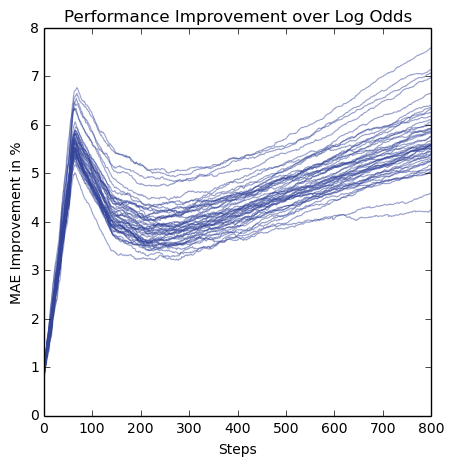

In [67]:
%matplotlib inline
fig, (ax) = plt.subplots(1, 1, figsize=(5, 5))
ax.set_title("Performance Improvement over Log Odds")
ax.set_xlabel("Steps")
ax.set_ylabel("MAE Improvement in %")
  
directory_name = "../build/different_maps/"
print "Plotting from %s ..." % directory_name
filenames = sorted(
    glob.glob(directory_name + "*.bag"),
    key=lambda f: int(re.findall('([0-9]+)', f[len(directory_name):])[0]))[1:]

steps = 0

k = 2

final_improvements = []
for rnd, filename in enumerate(filenames):
#         print "Evaluating round %i (%s)..." % (rnd, filename)
    bag = rosbag.Bag(filename)
    stats = None
    for _, msg, _ in bag.read_messages(topics=['stats']):
        stats = msg
    bag.close()
    if stats is None:
        continue

    steps = stats.step        
    
    err_belief = np.array(stats.errorEvolutionUpdatedBelief)
    err_logodds = np.array(stats.errorEvolutionUpdatedLogOdds)
    improvement = (err_logodds - err_belief)/err_belief*100
    ax.plot(improvement, label=filename, color="#334499", alpha=0.5, linewidth=.8, antialiased=True)
    errBelief = np.abs(np.array(stats.errorBelief))
    stdBelief = np.array(stats.stdBelief)
    errLogOdds = np.abs(np.array(stats.errorLogOdds))
    stdLogOdds = np.array(stats.stdLogOdds)

    mask = (np.abs(errBelief-0.5) > 0.01) | (np.abs(errLogOdds-0.5) > 0.01)
    errLogOdds = errLogOdds[mask]
    stdLogOdds = stdLogOdds[mask]
    errBelief = errBelief[mask]
    stdBelief = stdBelief[mask]

    inconsistencyLogOdds = np.sum([max(0, err - k * std) for err, std in zip(errLogOdds, stdLogOdds)])
    inconsistencyBelief = np.sum([max(0, err - k * std) for err, std in zip(errBelief, stdBelief)])

    print "inconsistencyLogOdds:", inconsistencyLogOdds
    print "inconsistencyBelief:", inconsistencyBelief
    
    improvement = (np.sum(errLogOdds)-np.sum(errBelief))/np.sum(errBelief)*100
    print "CRM improvement over Log-Odds:", improvement, "%"
    final_improvements.append(improvement)
    
plt.savefig("perf_improvement.pdf")
print "Mean Improvement:", np.mean(final_improvements)
print "Std Improvement:", np.std(final_improvements)